In [1]:
import random
import json
import numpy as np
import pandas as pd
from datetime import datetime

import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchvision.models._utils import IntermediateLayerGetter

from models.modeling.deeplab import *
from dataloader.talk2car import *

import denseCRF
import pydensecrf.densecrf as dcrf

from PIL import Image
from skimage.transform import resize

from losses import Loss
from models.model import JointModel

from utils.im_processing import *
from utils.metrics import *

from summarizer import Summarizer

from collections import Counter

comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [3]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 1
    dropout = 0.25
    skip_conn = False
    model_path = "./saved_model/talk2car/deeplabv3_plus_talk2car_1_bce_0.52071.pth"
    loss = "bce"
    dataroot = "/ssd_scratch/cvit/kanishk/"
    glove_path = "/ssd_scratch/cvit/kanishk/glove/"
    dataset = "talk2car"
    task = "talk2car"
    split = "val"
    seq_len = 25
    image_dim = 448
    mask_dim = 448
    mask_thresh = 0.3
    area_thresh = 0.4
    topk = 10
    metric = "intersection_at_t"

args = Args()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [5]:
print("Initializing dataset")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))


val_dataset = Talk2Car(
    root=args.dataroot,
    split=args.split,
    transform=transforms.Compose([resize, to_tensor, normalize]),
    mask_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
    glove_path=args.glove_path
)

# val_loader = DataLoader(
#     val_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True
# )

Initializing dataset


In [6]:
val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True
)

In [7]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)

In [8]:
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 

<All keys matched successfully>

In [9]:
if n_gpu > 1:
    image_encoder = nn.DataParallel(image_encoder)

joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [10]:
summarizer = Summarizer()

In [11]:
loss_func = Loss(args)
val_iter = iter(val_loader)

In [12]:
def compute_mask_IOU(masks, target, thresh=0.3):
    assert(target.shape[-2:] == masks.shape[-2:])
    temp = ((masks>thresh) * target)
    intersection = temp.sum()
    union = (((masks>thresh) + target) - temp).sum()
    return intersection, union

def meanIOU(m, gt, t):
    temp = ((m > t)*gt)
    inter = temp.sum()
    union = ((m > t) + gt - temp).sum()
    return inter/union

### Example Visualization

In [13]:
val_iter = iter(val_loader)

In [14]:
data_len = val_dataset.__len__()
indx = random.choice(range(data_len))
batch = val_dataset.__getitem__(indx)

In [15]:
indices = random.sample(range(data_len), 2)
# indices = list(range(data_len))

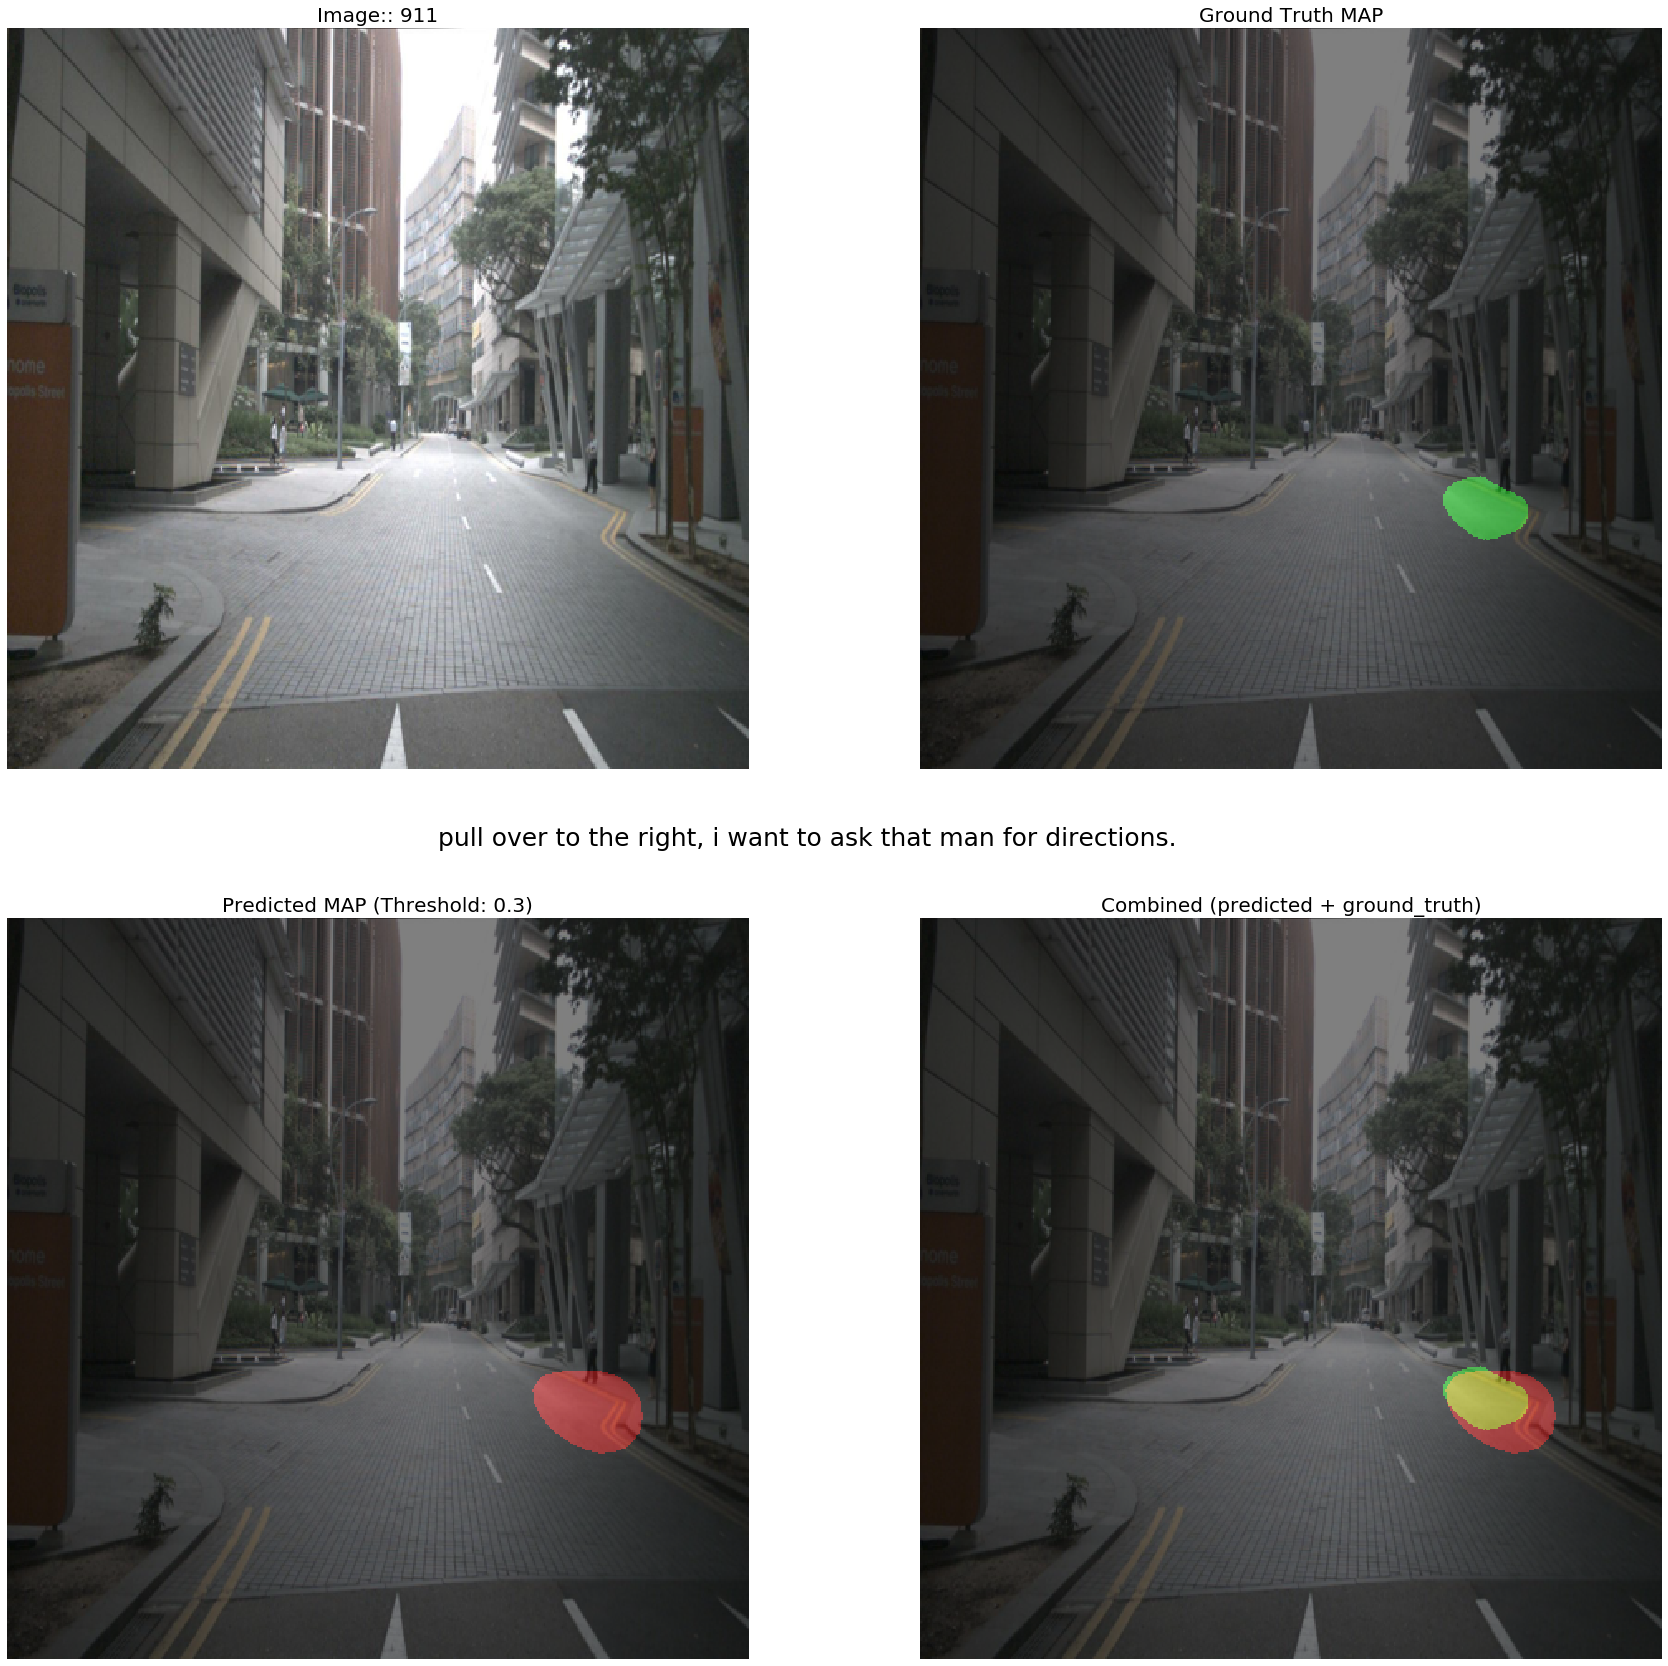

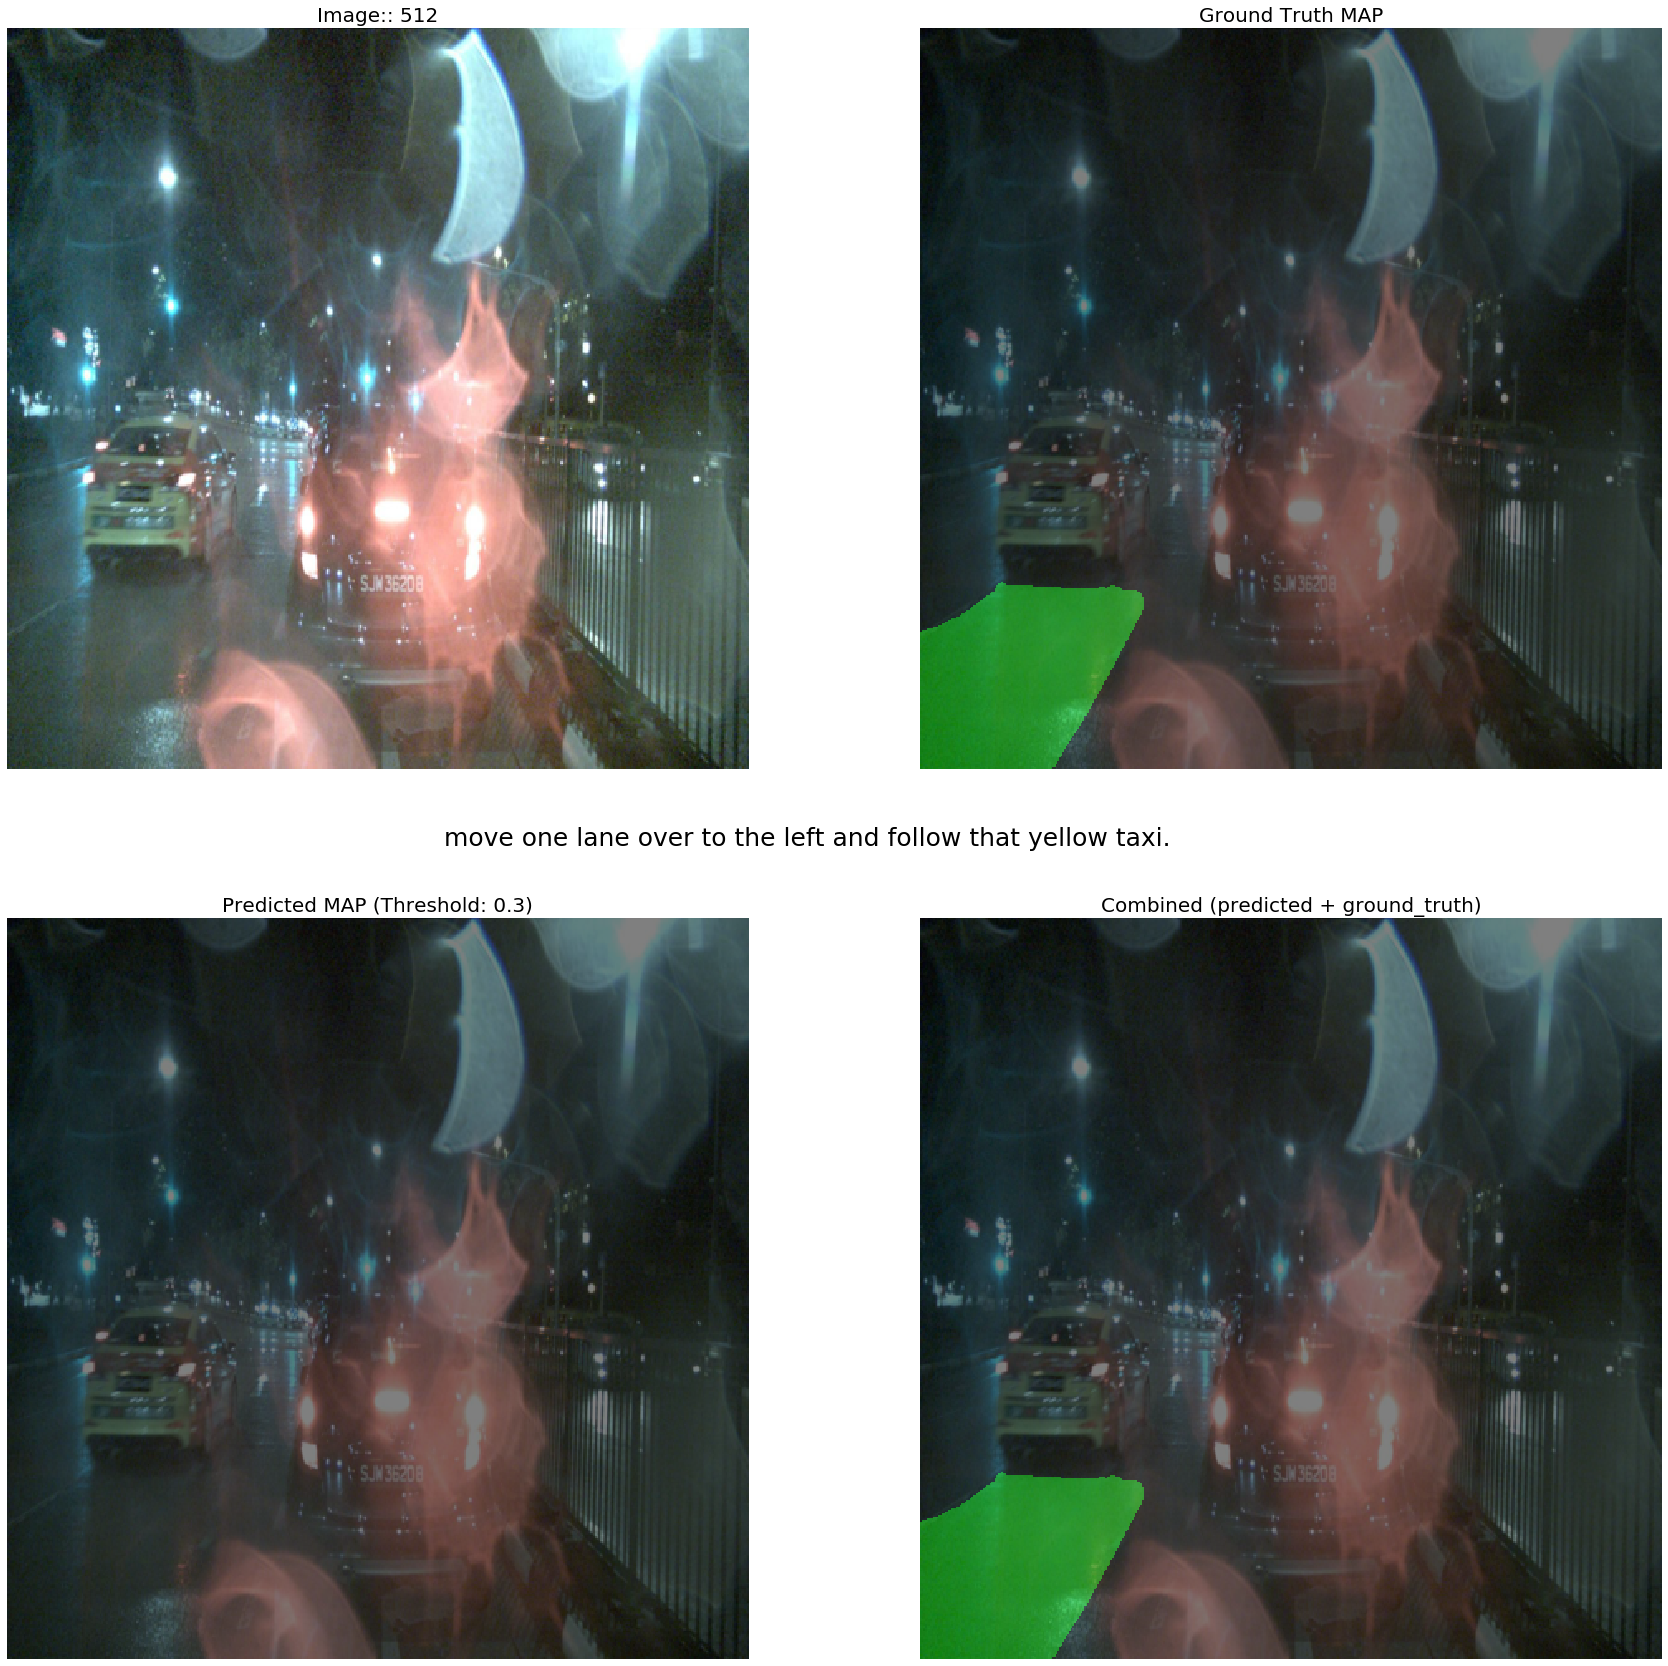

In [16]:
best_counter = Counter()
# with PdfPages(f'results_full_{args.mask_thresh}.pdf') as pdf:
for indx in indices:

    batch = val_dataset.__getitem__(indx)

    img = batch["image"].cuda(non_blocking=True).unsqueeze(0)

    # phrase = batch["phrase"].cuda(non_blocking=True)
    # phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

    ### Custom Phrase ###
    # batch["orig_phrase"] = "park near the left car"
    # batch["orig_phrase"] = summarizer(batch["orig_phrase"])
    phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
    phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
    phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

    gt_mask = batch["seg_mask"]
    gt_mask = gt_mask.squeeze(dim=1)

    batch_size = img.shape[0]
    img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

    with torch.no_grad():
        img = image_encoder(img)  # ['out']

    output_mask = joint_model(img, phrase, img_mask, phrase_mask)

    output_mask = output_mask.detach().cpu().squeeze()
    mask_out = output_mask[0]

    loss = loss_func(output_mask, gt_mask).item()
    inter, union = compute_mask_IOU(output_mask, gt_mask)

    score = inter / union

    orig_image = batch["orig_image"] #.numpy()
    orig_phrase = batch["orig_phrase"]

    # orig_mask = batch["orig_mask"]

    example = {
        "image": orig_image,
        "phrase": orig_phrase,
        "mask_gt": gt_mask,
        "mask_pred": output_mask,
        # "orig_mask": orig_mask,
    }

    image = example["image"] #[0]
    phrase = example["phrase"]
    mask_gt = example["mask_gt"]#[0]
    mask_pred = example["mask_pred"]#[0]

    # im = (image * 255).astype('uint8')
    im = image

    iou = []
    thr = []
    cum_sum = []

    t_ = 0.0

    best_t = t_
    best_iou = 0

    while t_ < 1:
        miou = meanIOU(output_mask, gt_mask, t_)
        cum_sum.append((output_mask > t_).sum())
        iou.append(miou)
        thr.append(t_)

        if best_iou < miou:
            best_iou = miou
            best_t = t_

        t_ += 0.05

    if best_t == 0:
        best_t += 0.0001

    best_counter.update({best_t:1})

    ## Prediction
    im_seg = im[:] / 2
    predicts = (mask_pred > args.mask_thresh).numpy()

    ## Combined
    im_comb = im[:] / 2

    ## Ground Truth
    im_gt = im[:] / 2
    gt = (mask_gt > 0).numpy()

    ## Prediction 
    im_seg[:, :, 0] += predicts.astype('uint8') * 100
    im_seg = im_seg.astype('uint8')

    ## Best Threshold
    im_comb[:, :, 0] += predicts.astype('uint8') * 100
    im_comb[:, :, 1] += gt.astype('uint8') * 100
    im_comb = im_comb.astype('uint8')

    ## Ground Truth
    im_gt[:, :, 1] += gt.astype('uint8') * 100
    im_gt = im_gt.astype('uint8')


    figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))

    axes[0, 0].imshow(im)
    axes[0, 0].set_title(f"Image:: {indx}", fontsize=20)
    axes[0, 0].axis("off")

    axes[0, 1].imshow(im_gt)
    axes[0, 1].set_title("Ground Truth MAP", fontsize=20)
    axes[0, 1].axis("off")

    axes[1, 0].imshow(im_seg)
    axes[1, 0].set_title(f"Predicted MAP (Threshold: {args.mask_thresh})", fontsize=20)
    axes[1, 0].axis("off")

    axes[1, 1].imshow(im_comb)
    axes[1, 1].set_title(f"Combined (predicted + ground_truth)", fontsize=20)
    axes[1, 1].axis("off")

    figure.suptitle(f"{phrase}", y=0.51, fontsize=25)
    
    plt.show()

    # pdf.savefig(figure)

    # plt.cla()
    # plt.clf()
    # plt.close()


In [17]:
print(best_counter)

Counter({0.5499999999999999: 1, 0.0001: 1})


### Command Analysis

In [18]:
with open("/home/kanishk/vigil/autonomous_grounding/dataloader/talk2car_w_rpn_no_duplicates.json", "rb") as f:
    data = json.load(f)[args.split]
    data = {int(k): v for k, v in data.items()}
img_dir = os.path.join(args.dataroot, "imgs")
mask_dir = os.path.join(args.dataroot, "mask_image_bin")

data_len = len(data)
print(f'Total Examples in {args.split} set: {data_len}')

Total Examples in val set: 1163


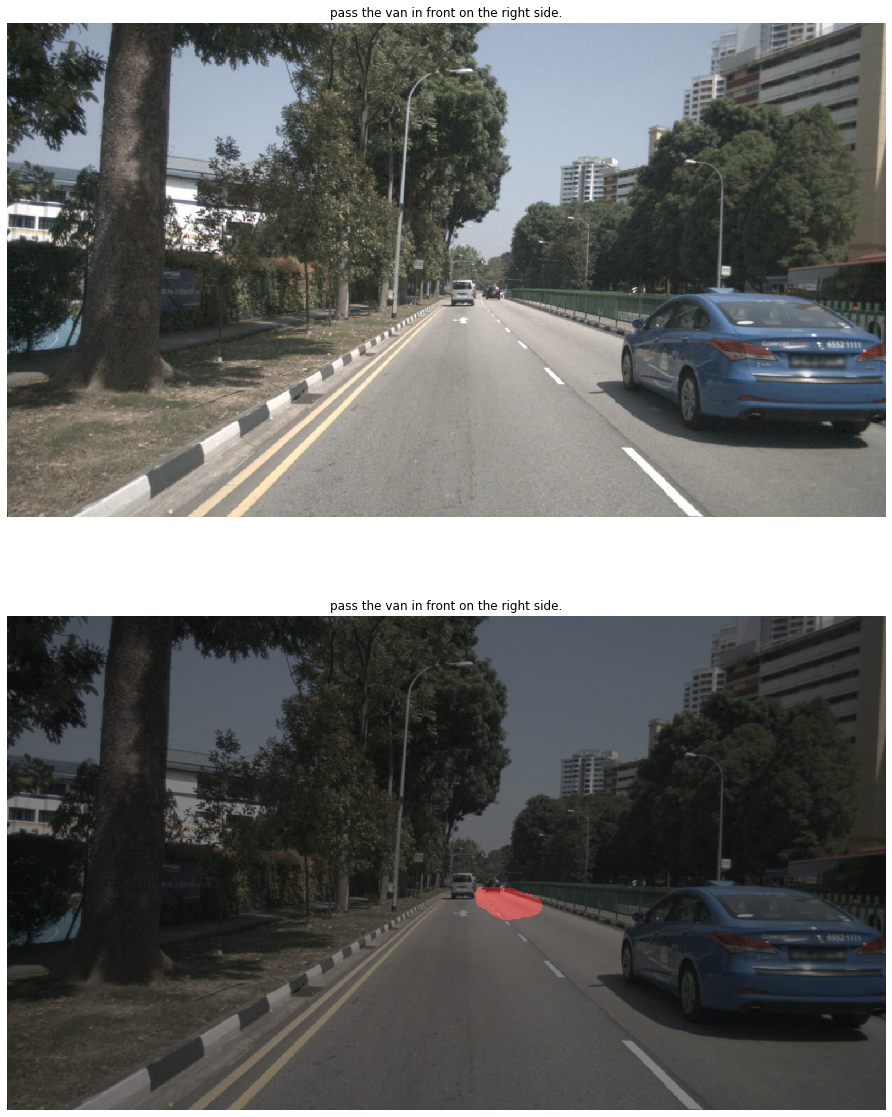

In [19]:
index = random.choice(range(data_len))
command = data[index]['command']

img_file = data[index]['img']
img_path = os.path.join(img_dir, img_file)

mask_file = f"gt_img_ann_{args.split}_{index}.png"
mask_path = os.path.join(mask_dir, mask_file)

img = Image.open(img_path)
img = np.array(img)

mask = Image.open(mask_path)
mask = np.array(mask)

img_overlay = img[:] / 2
mask_ = (mask > 0)
img_overlay[:, :, 0] += mask_.astype('uint8') * 100
img_overlay = img_overlay.astype('uint8')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

ax[0].imshow(img)
ax[0].set_title(command)
ax[0].set_axis_off()

ax[1].imshow(img_overlay)
ax[1].set_title(command)
ax[1].set_axis_off()

plt.show()

In [20]:
simple_command = summarizer(command)

In [21]:
print(f'Original Command:: {command}')
print(f'Simple Command:: {simple_command}')

Original Command:: pass the van in front on the right side.
Simple Command:: 


In [22]:
keywords = ["stop", "slow", "wait", "then", "speed", "change", "continue", "follow", "u-turn", "once"]

In [99]:
def intersection(command):
    count = 0
    words = []
    for key in keywords:
        if key in command:
            words.append(key)
            count += 1
    return count, words

In [60]:
non_temporal_count = 0
temporal_count = 0

max_word_count = 0

# command_dict = {}
# for key in keywords:
#     command_dict[key] = 0

counter = Counter()

max_len = 0

for ind in range(data_len):
    command = data[ind]['command']
    
    max_len = max(max_len, len(command.split()))
    
    for key in keywords:
        if key in command:
            counter.update({key:1})
    
    inter_count, inter_words = intersection(command)
    
    if inter_count == 0:
        non_temporal_count += 1
    else:
        temporal_count += 1
        if inter_count > max_word_count:
            max_word_count = inter_count
            print(command)
            print(inter_words, inter_count)

once the light turns green, turn left behind the silver car
['once'] 1
oh i see my friends white car that is parked over there. stop near by once you make the left turn.
['stop', 'once'] 2
pull over behind this bus and stop. once traffic is clear make a you-turn and drive in the opposite direction.
['stop', 'u-turn', 'once'] 3
see if the guy is waiting to cross the street. if so stop and let him pass then continue driving straight.
['stop', 'wait', 'then', 'continue'] 4


In [61]:
max_len

32

In [25]:
print(max_word_count, temporal_count, non_temporal_count)

4 452 711


In [26]:
print(counter, sum(counter.values()))

Counter({'stop': 149, 'follow': 135, 'slow': 76, 'wait': 44, 'continue': 27, 'then': 26, 'change': 24, 'u-turn': 18, 'once': 13, 'speed': 13}) 525


### Evaluation Metrics

In [109]:
keywords = ["stop", "slow", "wait", "then", "speed", "change", "continue", "follow", "u-turn", "once"]

def intersection(command):
    count = 0
    words = []
    for key in keywords:
        if key in command:
            words.append(key)
            count += 1
    return count, words

In [110]:
print("Temporal Keywords")
print(keywords)

Temporal Keywords
['stop', 'slow', 'wait', 'then', 'speed', 'change', 'continue', 'follow', 'u-turn', 'once']


In [111]:
args.metric = "intersection_at_t"

args.mask_thresh = 0.3

image_encoder.eval()
joint_model.eval()

total_inter = 0
total_union = 0

total_accuracy = 0

# result_map = {
#     '0-5': {},
#     '5-10': {},
#     '10-15': {},
#     '15-20': {},
#     '20-25': {},
#     '25-': {}
# }

# result_map = {
#     'non-temporal': {},
#     'temporal': {},
# }

# result_map = {}

result_map = {key: {} for key in keywords}

mean_IOU = 0

prec_at_x = {0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}

data_len = len(val_loader)

n_iter = 0

for step, batch in enumerate(val_loader):

    img = batch["image"].cuda(non_blocking=True)

    phrase = batch["phrase"].cuda(non_blocking=True)
    phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)
    index = batch["index"]

    gt_mask = batch["seg_mask"]
    gt_mask = gt_mask.squeeze(dim=1)

    batch_size = img.shape[0]
    img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(
        non_blocking=True
    )
    
    orig_phrase = batch["orig_phrase"][0]
    phrase_len = len(orig_phrase.split())
    
    with torch.no_grad():
        img = image_encoder(img)

    output_mask = joint_model(img, phrase, img_mask, phrase_mask)
    output_mask = output_mask.detach().cpu()
    
    count, inter_words = intersection(orig_phrase)
    
    # if count not in result_map:
    #     result_map[count] = {}
    
    if count == 0:
        continue
    
    for area_thresh in [0.1, 0.2, 0.3, 0.4, 0.5]:
        
        n_iter += 1
        
        inter, union = compute_batch_IOU(output_mask, gt_mask, args.mask_thresh)

        total_inter += inter.sum().item()
        total_union += union.sum().item()

        accuracy = 0
        if args.metric == "pointing_game":
            accuracy += pointing_game(output_mask, gt_mask)
        elif args.metric == "intersection_at_t":
            accuracy += intersection_at_t(output_mask, gt_mask, args.mask_thresh, area_thresh)
        elif args.metric == "recall_at_k":
            accuracy += recall_at_k(output_mask, target, args.topk)
        elif args.metric == "dice_score":
            accuracy += dice_score(output_mask, gt_mask, args.mask_thresh)
        
        # ############## PHRASE LEN ANALYSIS ###############
        # if phrase_len < 5:
        #     if area_thresh not in result_map['0-5']:
        #         result_map['0-5'][area_thresh] = []
        #     result_map['0-5'][area_thresh].append(accuracy)
        # elif phrase_len < 10:
        #     if area_thresh not in result_map['5-10']:
        #         result_map['5-10'][area_thresh] = []
        #     result_map['5-10'][area_thresh].append(accuracy)
        # elif phrase_len < 15:
        #     if area_thresh not in result_map['10-15']:
        #         result_map['10-15'][area_thresh] = []
        #     result_map['10-15'][area_thresh].append(accuracy)
        # elif phrase_len < 20:
        #     if area_thresh not in result_map['15-20']:
        #         result_map['15-20'][area_thresh] = []
        #     result_map['15-20'][area_thresh].append(accuracy)
        # elif phrase_len < 25:
        #     if area_thresh not in result_map['20-25']:
        #         result_map['20-25'][area_thresh] = []
        #     result_map['20-25'][area_thresh].append(accuracy)
        # else:
        #     if area_thresh not in result_map['25-']:
        #         result_map['25-'][area_thresh] = []
        #     result_map['25-'][area_thresh].append(accuracy)
        # ####################################################
        
        # ############ TEMPORAL WORD COUNT #################
        # if area_thresh not in result_map[count]:
        #     result_map[count][area_thresh] = []
        # result_map[count][area_thresh].append(accuracy)
        # ##################################################
        
        ############ TEMPORAL WORDs #################
        for word in inter_words:
            if area_thresh not in result_map[word]:
                result_map[word][area_thresh] = []
            result_map[word][area_thresh].append(accuracy)
        ##################################################
        
        # ################### TEMPORAL LENGTH ######################
        # if count > 0:
        #     if area_thresh not in result_map['temporal']:
        #         result_map['temporal'][area_thresh] = []
        #     result_map['temporal'][area_thresh].append(accuracy)
        # else:
        #     if area_thresh not in result_map['non-temporal']:
        #         result_map['non-temporal'][area_thresh] = []
        #     result_map['non-temporal'][area_thresh].append(accuracy)
        # ############################################################
                
        score = 0 if union.item() == 0 else inter.item() / union.item()

        mean_IOU += score

        total_score = total_inter / total_union

        for x in prec_at_x:
            if score > x:
                prec_at_x[x] += 1

overall_IOU = total_inter / total_union
mean_IOU = mean_IOU / data_len

print(f"Mean_IOU: {mean_IOU}, Total: {n_iter}")

for x in prec_at_x:
    percent = (prec_at_x[x] / data_len) * 100
    print(f"{x}% IOU: {percent}%")

print("==================================")

Mean_IOU: 0.35266342713423854, Total: 2260
0.5% IOU: 22.785898538263112%
0.6% IOU: 12.037833190025795%
0.7% IOU: 4.299226139294927%
0.8% IOU: 0.0%
0.9% IOU: 0.0%


In [112]:
### Short Vs Long Phrases AND Temporal Vs Non-Temporal
print(f'Results at mask_thresh: {args.mask_thresh}')

refined_map = {}
for key1 in result_map:
    refined_map[key1] = {}
    total_len = 0
    for key2 in result_map[key1]:
        total_len += len(result_map[key1][key2])
        accuracy = torch.tensor(result_map[key1][key2])
        refined_map[key1][f'Inter@{key2}'] = accuracy.mean().item()
    refined_map[key1]['count'] = total_len // len(result_map[key1])

df_result = pd.DataFrame.from_dict(refined_map,orient='index')
df_result.index.name = 'temporal keywords'

df_result

Results at mask_thresh: 0.3


Inter@0.1  Inter@0.2  Inter@0.3  Inter@0.4  Inter@0.5  \
temporal keywords                                                          
stop                0.644295   0.570470   0.510067   0.476510   0.416107   
slow                0.460526   0.407895   0.381579   0.328947   0.302632   
wait                0.590909   0.590909   0.545455   0.477273   0.431818   
then                0.576923   0.538462   0.461538   0.384615   0.307692   
speed               0.461538   0.384615   0.307692   0.307692   0.307692   
change              0.625000   0.625000   0.583333   0.416667   0.375000   
continue            0.518519   0.444444   0.407407   0.333333   0.296296   
follow              0.481481   0.444444   0.414815   0.370370   0.340741   
u-turn              0.555556   0.388889   0.388889   0.222222   0.222222   
once                0.384615   0.307692   0.307692   0.307692   0.307692   

                   count  
temporal keywords         
stop                 149  
slow                  76  
wait                  44  
then                  26  
speed                 13  
change                24  
continue              27  
follow               135  
u-turn                18  
once                  13

In [103]:
# 31 + 470 + 425 + 162 + 56 + 19
# 711 + 452

1163

In [97]:
### Sentences [0, 5] (Total 31)

# Threshold | Inters@0.5 | Inter@0.4 | Inter@0.3 | Inter@0.2 | Inter@0.1 | Overall IOU | Mean IOU |
#     0.3   |    32.22   |    38.70  |    41.93  |    48.38  |    54.83  |     24.82   |   17.02  |


### Sentences [5, 10] (Total 422)

# Threshold | Inters@0.5 | Inter@0.4 | Inter@0.3 | Inter@0.2 | Inter@0.1 | Overall IOU | Mean IOU |
#     0.3   |    41.94   |    47.86  |    53.55  |    58.76  |    63.74  |     23.51   |   23.71  |

### Sentences [10, 15] (Total ---)

# Threshold | Inters@0.5 | Inter@0.4 | Inter@0.3 | Inter@0.2 | Inter@0.1 | Overall IOU | Mean IOU |
#     0.3   |    --.--   |    --.--  |    --.--  |    --.--  |    --.--  |     --.--   |   --.--  |